# Kinetic Hypothesis Testing Using SKAI Package | Case Study 1
In this notebook, we will go over:  
1.   How to initilize reactions system in SKAI
2.   How to simulate a system of ODEs for a given reaction mechanism 
3.   How to visualize the SKAI ODE solver and plot them against experimental data
4.   How to run a bayesain regression for a testing a hyptothesis based on expeirmental data 
5.  How to define multiple reaction systems and compare and rank the model


**Authored by:**  Xiao Li, Reza Amirmoshiri, Yasser Jangjou
@ Sanofi CMC synthetics 

**Reactions:**

$$
\begin{align*}
  R1. & \;\; \text{Starting Material + Base + Reagent} \rightarrow \text{Product + Base} \\
  R2. & \;\; \text{Product + Base + Reagent} \rightarrow \text{Impurity + Base}
\end{align*}
$$
**Rate Equations:**
$$
\begin{align*}
  R_{1f} & = k_{1f} \times e^{(-E_{1f}/RT)} \times C^m_{\text{starting material}} \times C^n_{\text{reagent}}  \times C^p_{\text{base}}\\
  R_{2f} & = k_{2f} \times e^{(-E_{2f}/RT)} \times C^m_{\text{product}} \times C^n_n{\text{reagent}}   \times C^p_{\text{base}}
\end{align*}
$$

</div>



In [1]:
import jax.numpy as jnp
import pandas as pd
import arviz as az 
import numpyro
import numpyro.distributions as dist
import jax
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# SKAI imports 

# symbolic ODE solver from SKAI 
from BI.utilities.reaction_solver import SymbolicRXNSolver

# bayesian inference from SKAI
from BI.models.Inference import BayesianKineticAI


c:\Users\MalakM02\AppData\Local\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Section 1. Import initial conditions & fitted parameters using an ODE solver (Dynochem)

In [2]:
 
# define the initial conditions

                 # T  SM_0   R_0   B_0 
X1 = jnp.array([81.9, 0.208, 0.2, 0.405])
X2 = jnp.array([81.9, 0.203, 0.4, 0.405])
X3 = jnp.array([81.9, 0.204, 0.2, 0.811])
X4 = jnp.array([61.1, 0.209, 0.2, 0.406])
X5 = jnp.array([71.0, 0.209, 0.2, 0.407])

X1 = jnp.reshape(X1, (4, 1))
X2 = jnp.reshape(X2, (4, 1))
X3 = jnp.reshape(X3, (4, 1))
X4 = jnp.reshape(X4, (4, 1))
X5 = jnp.reshape(X5, (4, 1))

input_matrix = jnp.concatenate([X1, X2, X3, X4, X5], axis=1)

time = jnp.array([0.0, 15.0, 30.0, 45.0, 60.0, 90.0, 120.0, 180.0, 240.0, 360.0, 480.0, 540.0, 600.0, 780.0, 900.0, 960.0, 1207.0, 1374.0])


ground_truth_params = {
"k1_f": 0.011,
"E1_f": 70.2E3,   
"k2_f": 0.002,
"E2_f": 78.92E3,
}

    #   E1_f     11.30      0.03     11.30     11.26     11.35    198.15      1.00
    #   E2_f     11.41      0.19     11.46     11.17     11.60    244.69      1.01
    #   k1_f      4.46      0.02      4.46      4.43      4.50    233.74      1.01
    #   k2_f      6.05      0.07      6.05      5.93      6.17    292.57      1.00
mean_params = {
"k1_f": jnp.exp(-4.46),
"E1_f": jnp.exp(10.85 ),
"k2_f": jnp.exp(-6.01),
"E2_f": jnp.exp(10.84),
}

mean_params2 = {
"k1_f": jnp.exp(-4.46),
"E1_f": jnp.exp(11.30 ),
"k2_f": jnp.exp(-6.01),
"E2_f": jnp.exp(11.41-0.19),
}


## Section 2. Define reaction system in SKAI

In [3]:
# Mechanism #1
# R1.    SM + B + R -> P + B,  
# R2.    P + B +  R -> IMP2 + B

reactions_example_1 = {
    'rxn1': {
        'reactants': {'SM': 1, 'reagent': 1, 'base':1},
        'products': {'product': 1, 'base': 1},
        'k_f': 0.01,
        'E_f': 70E3,
        'reversible': False,  
        'T_ref':273.15+81.9,
        'Rxn_orders_f': {'SM':1, 'reagent': 1, 'base':1}, 
        'Rxn_orders_b': '',
    },

    'rxn2': {   
        'reactants': {'product': 1, 'reagent': 1, 'base':1},
        'products': {'IMP1': 1},
        'k_f': 0.002,
        'E_f': 78E3,
        'reversible': False, 
        'T_ref':273.15+81.9, 
        'Rxn_orders_f': {'product':1, 'reagent': 1, 'base':1},
        'Rxn_orders_b': '', 
        
    }
}

reaction1 = SymbolicRXNSolver(reactions_example_1)
reaction1.reaction_table()



reactions_exp = reaction1.write_reaction_rate_expressions()
for reaction_name in reactions_exp.items():
    print(f"{reaction_name}")

ode_expressions = reaction1.write_ODE_system()
for species in ode_expressions[0]:
    equation_str = ode_expressions[0][species]
    print(equation_str)

Reaction:

+----------+-----------------------------+-----+------------------+-------+---------+-------+-------+-------------+
| Reaction | Reactants                   |     | Products         | k (f) | E (f)   | k (b) | E (b) | Reversible? |
+----------+-----------------------------+-----+------------------+-------+---------+-------+-------+-------------+
| rxn1     | 1SM + 1reagent + 1base      | --> | 1product + 1base | 0.01  | 70000.0 | 0     | 0     | False       |
| rxn2     | 1product + 1reagent + 1base | --> | 1IMP1            | 0.002 | 78000.0 | 0     | 0     | False       |
+----------+-----------------------------+-----+------------------+-------+---------+-------+-------+-------------+
('rxn1', {'forward': 'Rrxn1_f = krxn1_f * SM^1 reagent^1 base^1', 'backward': ''})
('rxn2', {'forward': 'Rrxn2_f = krxn2_f * product^1 reagent^1 base^1', 'backward': ''})
dreagent/dt = -1 * Rate_rxn1_forward + -1 * Rate_rxn2_forward
dSM/dt = -1 * Rate_rxn1_forward + 0
dbase/dt = -1 * Rate_rxn

In [ ]:
# Mechanism #1
# R1.  SM + B + R -> P + B
# R2.  SM + P + B -> IMP2 + B


reactions_example_2 = {
    'rxn1': {
        'reactants': {'SM': 1, 'reagent': 1, 'base':1},
        'products': {'product': 1, 'base':1},
        'k_f': 0.1,
        'E_f': 70E3,
        'reversible': False,  
        'T_ref':273.15+81.9,
        'Rxn_orders_f': {'SM':1, 'reagent': 1, 'base':1}, 
        'Rxn_orders_b': '',
    },

    'rxn2': {
        'reactants': {'SM': 1, 'product': 1, 'base':1},
        'products': {'IMP2': 1, 'base':1},
        'k_f': 0.002,
        'E_f': 77E3,
        'reversible': False, 
        'T_ref':273.15+81.9, 
        'Rxn_orders_f': {'SM':1, 'product': 1, 'base':1},
        'Rxn_orders_b': '', 
        
    }
}


reaction2 = SymbolicRXNSolver(reactions_example_2)
reaction2.reaction_table()

reactions_exp = reaction2.write_reaction_rate_expressions()
for reaction_name in reactions_exp.items():
    print(f"{reaction_name}")

ode_expressions = reaction2.write_ODE_system()
for species in ode_expressions[0]:
    equation_str = ode_expressions[0][species]
    print(equation_str)

In [ ]:
# mechanism 3
# R1.  SM + B + R -> P + B + INT1  
# R2.   B + INT1 -> P + B

reactions_example_3 = {
    'rxn1': {
        'reactants': {'SM': 1, 'reagent': 1, 'base':1},
        'products': {'INT1': 1, 'base':1, 'product':1},
        'k_f': 0.1,
        'E_f': 70E3,
        'reversible': False,  
        'T_ref':273.15+81.9,
        'Rxn_orders_f': {'SM':1, 'reagent': 1, 'base':1},
        'Rxn_orders_b': '',
    },

    'rxn2': {
        'reactants': {'base': 1, 'INT1':1},
        'products': {'IMP2': 1, 'product':1},
        'k_f': 0.002,
        'E_f': 77E3,
        'reversible': False, 
        'T_ref':273.15+81.9, 
        'Rxn_orders_f': {'base': 1, 'INT1':1},
        'Rxn_orders_b': '', 
        
    }
}
reaction3 = SymbolicRXNSolver(reactions_example_3)
reaction3.reaction_table()


reactions_exp = reaction3.write_reaction_rate_expressions()
for reaction_name in reactions_exp.items():
    print(f"{reaction_name}")

ode_expressions = reaction3.write_ODE_system()
for species in ode_expressions[0]:
    equation_str = ode_expressions[0][species]
    print(equation_str)

## Section 2. Kinetic hypothesis testing


### Step 1. Define initial conditions & import experimental data

In [3]:
# experimental data
df_raw = pd.read_csv("example_2_experimental_data2.csv")

# initial conditions
input_data_for_case_study_1 = pd.read_csv('Initial_conditions_example2.csv').to_dict(orient='list')
input_data_for_case_study_1.keys()

dict_keys(['T', 'SM', 'base', 'reagent', 'time'])

In [4]:
# Reading intial conditions and put them into a jnp array as the main input "X_measured" 

T              = jnp.array(input_data_for_case_study_1['T'])
SM             = jnp.array(input_data_for_case_study_1['SM'])
reagent        = jnp.array(input_data_for_case_study_1['reagent'])
base           = jnp.array(input_data_for_case_study_1['base'])
time           = jnp.array(input_data_for_case_study_1['time'])


X_measured     = jnp.column_stack((T, SM, reagent, base, time))

In [5]:
# Preparing the experimental data and save them in a 1D array as y_exp_data 

SM_measured = []
P_measured = []
IMP_measured = []

for i in range(0, 5):
    SM_measured.append(df_raw.iloc[:, i * 4 + 1])
    P_measured.append(df_raw.iloc[:, i * 4 + 2])
    IMP_measured.append(df_raw.iloc[:, i * 4 + 3])


non_nan_values_SM  = np.concatenate(SM_measured)
non_nan_values_P   = np.concatenate(P_measured)
non_nan_values_IMP = np.concatenate(IMP_measured)


# # Calculate the measured_Y_without_Nan using non-NaN values arrays   
# ******NOTE ******this is where we apply weighting factor
# measured_Y_without_Nan =  non_nan_values_P +  non_nan_values_IMP
measured_Y_without_Nan = 0.8* non_nan_values_P + 0.1*non_nan_values_SM + 0.1*non_nan_values_IMP
nan_mask = jnp.isnan(measured_Y_without_Nan)
y_without_nan = measured_Y_without_Nan[~nan_mask]

# adding noise
noise_level = 0.0001
noise = np.random.normal(0, noise_level, y_without_nan.shape)
y_exp_data = y_without_nan + noise
X_dummy = X_measured
Y_dummy = y_exp_data
 

### Step 2. Hypothesis testing using Bayesian Inference

C:\Users\MalakM02\AppData\Local\Temp\ipykernel_25068\2867420388.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


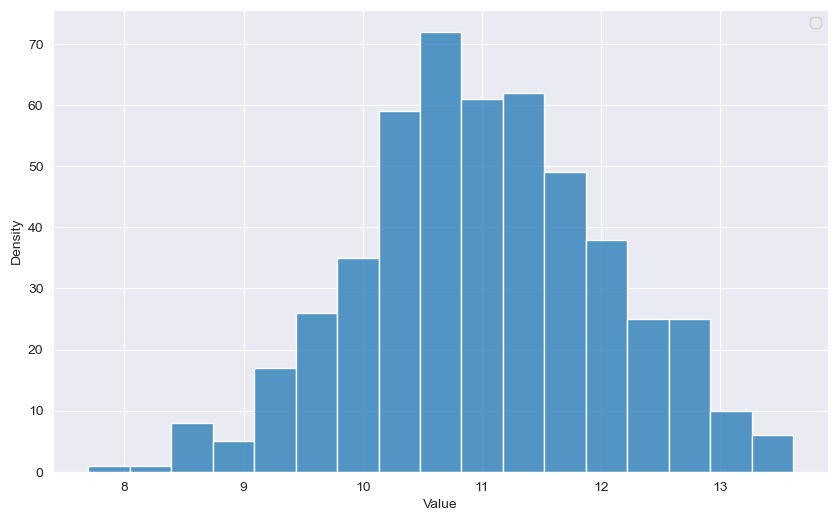

In [7]:


numpyro.set_host_device_count(4)
numpyro.set_platform("cpu")
numpyro.enable_validation()
jax.random.PRNGKey(42)
mu = 0
sigma = 1


# Generate samples from the LogNormal distribution
distribution_ = dist.Normal(11, 1)
# distribution_ = dist.TruncatedNormal(11, 1, low=10, high=11.6)
# # distribution_  = dist.LogNormal(2.3, 0.1).expand_by([1]).to_event(1).mask(False)
num_samples = 500
# Sample from the distribution
samples =  distribution_.sample(jax.random.PRNGKey(123), (num_samples,))


fig = plt.figure(figsize=(10, 6))
sns.histplot(samples)
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [6]:
def _new_priors():
    k1_f = numpyro.sample("k1_f", dist.LogNormal(0, 1))
    E1_f = numpyro.sample("E1_f", dist.Normal(10, 1)) 
    k2_f = numpyro.sample("k2_f", dist.LogNormal(0, 1))
    E2_f = numpyro.sample("E2_f", dist.Normal(10, 1))
    return {"k1_f": k1_f,
            "E1_f": E1_f,
            "k2_f": k2_f,
            "E2_f": E2_f}

In [6]:
t = jnp.array([0.0, 15.0, 30.0, 45.0, 60.0, 90.0, 120.0, 180.0, 240.0, 360.0, 540.0, 900.0])
initial_species = ['SM', 'reagent', 'base']


In [ ]:
#### NOTE: make sure Acq function weights are similar to ones used to calculate Y_dummy!

In [ ]:
out = reaction1.initilize_ODE_solver_for_numpyro_input(X_dummy, t, initial_species, [0.1,0,0,0.1,0.9])


In [ ]:
BI_reaction1 = BayesianKineticAI()
BI_model = BI_reaction1.run_bayesian_inference(function = reaction1.simulate_symbolic_ode_for_numpyro,
    priors = _new_priors, 
    X= X_dummy[48:], 
    Y= Y_dummy[48:], 
    num_samples=2000,
    num_warmup=1000)

In [ ]:
#### NOTE: make sure Acq function weights are similar to ones used to calculate Y_dummy!

In [ ]:
out2 = reaction2.initilize_ODE_solver_for_numpyro_input(X_dummy, t, initial_species, [0.1,0,0,0.9,0.1])


In [ ]:
BI_reaction2 = BayesianKineticAI()
BI_model2 = BI_reaction2.run_bayesian_inference(function = reaction2.simulate_symbolic_ode_for_numpyro,
    priors = _new_priors, 
    X= X_dummy[48:], 
    Y= Y_dummy[48:], 
    num_samples=2000,
    num_warmup=1000)

#### NOTE: make sure Acq function weights are similar to ones used to calculate Y_dummy!

In [ ]:
out3 = reaction3.initilize_ODE_solver_for_numpyro_input(X_dummy, t, initial_species, [0.1,0,0,0.9,0, 0.1])

In [ ]:
BI_reaction3 = BayesianKineticAI()
BI_model3 = BI_reaction3.run_bayesian_inference(function = reaction3.simulate_symbolic_ode_for_numpyro,
    priors = _new_priors, 
    X= X_dummy[48:], 
    Y= Y_dummy[48:], 
    num_samples=200,
    num_warmup=100)

In [ ]:
models_ = {}
models_['model1'] = BI_model
models_['model2'] = BI_model2
models_['model3'] = BI_model3


In [ ]:
az.compare(models_)

In [ ]:
az.compare(models_, ic="waic")

## Finding the reaction order with respect to each initial species 

In [7]:
# reaction order check: 
# base order change

reactions_example_1_1 = {
    'rxn1': {
        'reactants': {'SM': 1, 'reagent': 1, 'base':1},
        'products': {'product': 1},
        'k_f': 0.01,
        'E_f': 70E3,
        'reversible': False,  
        'T_ref':273.15+81.9,
        'Rxn_orders_f': {'SM':1, 'reagent':1},
        'Rxn_orders_b': '',
    },

    'rxn2': {   
        'reactants': {'product': 1, 'reagent': 1, 'base':1},
        'products': {'IMP1': 1},
        'k_f': 0.002,
        'E_f': 78E3,
        'reversible': False, 
        'T_ref':273.15+81.9, 
        'Rxn_orders_f': {'product':1, 'reagent': 1},
        'Rxn_orders_b': '', 
        
    }
}

reaction1_1 = SymbolicRXNSolver(reactions_example_1_1)
reaction1_1.reaction_table()



reactions_exp = reaction1_1.write_reaction_rate_expressions()
for reaction_name in reactions_exp.items():
    print(f"{reaction_name}")

Reaction:

+----------+-----------------------------+-----+----------+-------+---------+-------+-------+-------------+
| Reaction | Reactants                   |     | Products | k (f) | E (f)   | k (b) | E (b) | Reversible? |
+----------+-----------------------------+-----+----------+-------+---------+-------+-------+-------------+
| rxn1     | 1SM + 1reagent + 1base      | --> | 1product | 0.01  | 70000.0 | 0     | 0     | False       |
| rxn2     | 1product + 1reagent + 1base | --> | 1IMP1    | 0.002 | 78000.0 | 0     | 0     | False       |
+----------+-----------------------------+-----+----------+-------+---------+-------+-------+-------------+
('rxn1', {'forward': 'Rrxn1_f = krxn1_f * SM^1 reagent^1', 'backward': ''})
('rxn2', {'forward': 'Rrxn2_f = krxn2_f * product^1 reagent^1', 'backward': ''})


In [ ]:
# reaction order check: 
# base

reactions_example_1_2 = {
    'rxn1': {
        'reactants': {'SM': 1, 'reagent': 1, 'base':1},
        'products': {'product': 1},
        'k_f': 0.01,
        'E_f': 70E3,
        'reversible': False,  
        'T_ref':273.15+81.9,
        'Rxn_orders_f': { 'SM': 1, 'reagent':1, 'base':2}, 
        'Rxn_orders_b': '',
    },

    'rxn2': {   
        'reactants': {'product': 1, 'reagent': 1, 'base':1},
        'products': {'IMP1': 1},
        'k_f': 0.002,
        'E_f': 78E3,
        'reversible': False, 
        'T_ref':273.15+81.9, 
        'Rxn_orders_f': {'product':1, 'reagent': 1, 'base':2},
        'Rxn_orders_b': '', 
        
    }
}

reaction1_2 = SymbolicRXNSolver(reactions_example_1_2)
reaction1_2.reaction_table()



reactions_exp = reaction1_2.write_reaction_rate_expressions()
for reaction_name in reactions_exp.items():
    print(f"{reaction_name}")

In [ ]:
out = reaction1.initilize_ODE_solver_for_numpyro_input(X_dummy, t, initial_species, [0.1,0,0,0.9,0.1])


In [ ]:
BI_reaction1 = BayesianKineticAI()
BI_model = BI_reaction1.run_bayesian_inference(function = reaction1.simulate_symbolic_ode_for_numpyro,
    priors = _new_priors, 
    X= X_dummy[:24], 
    Y= Y_dummy[:24], 
    num_samples=200,
    num_warmup=100)

In [ ]:
out = reaction1_1.initilize_ODE_solver_for_numpyro_input(X_dummy, time, initial_species, [0.1,0,0,0.9,0.1])

In [ ]:
BI_reaction1_1 = BayesianKineticAI()
BI_model1_1 = BI_reaction1_1.run_bayesian_inference(function = reaction1_1.simulate_symbolic_ode_for_numpyro,
    priors = _new_priors, 
    X= X_dummy[:24], 
    Y= Y_dummy[:24], 
    num_samples=200,
    num_warmup=100)

In [ ]:
out = reaction1_2.initilize_ODE_solver_for_numpyro_input(X_dummy, t, initial_species, [0.1,0,0,0.9,0.1])

In [ ]:

BI_reaction1_2 = BayesianKineticAI()
BI_model1_2 = BI_reaction1_2.run_bayesian_inference(function = reaction1_2.simulate_symbolic_ode_for_numpyro,
    priors = _new_priors, 
    X= X_dummy[:24], 
    Y= Y_dummy[:24], 
    num_samples=200,
    num_warmup=100)

In [ ]:
models_orders = {}
models_orders['fisrt order']  = BI_model
models_orders['zero order']   = BI_model1_1
models_orders['second order'] = BI_model1_2

az.compare(models_orders)

In [ ]:
# reaction order SM 
# reaction order check: 
# base

reactions_example_1_3 = {
    'rxn1': {
        'reactants': {'SM': 1, 'reagent': 1, 'base':1},
        'products': {'product': 1},
        'k_f': 0.01,
        'E_f': 70E3,
        'reversible': False,  
        'T_ref':273.15+81.9,
        'Rxn_orders_f': { 'reagent':1, 'base':1}, 
        'Rxn_orders_b': '',
    },

    'rxn2': {   
        'reactants': {'product': 1, 'reagent': 1, 'base':1},
        'products': {'IMP1': 1},
        'k_f': 0.002,
        'E_f': 78E3,
        'reversible': False, 
        'T_ref':273.15+81.9, 
        'Rxn_orders_f': {'product':1, 'reagent': 1, 'base':1},
        'Rxn_orders_b': '', 
        
    }
}

reaction1_3 = SymbolicRXNSolver(reactions_example_1_3)
reaction1_3.reaction_table()



reactions_exp = reaction1_3.write_reaction_rate_expressions()
for reaction_name in reactions_exp.items():
    print(f"{reaction_name}")

In [ ]:
# reaction order SM 
# reaction order check: 
# base

reactions_example_1_4 = {
    'rxn1': {
        'reactants': {'SM': 1, 'reagent': 1, 'base':1},
        'products': {'product': 1},
        'k_f': 0.01,
        'E_f': 70E3,
        'reversible': False,  
        'T_ref':273.15+81.9,
        'Rxn_orders_f': { 'SM': 2, 'reagent':1, 'base':1}, 
        'Rxn_orders_b': '',
    },

    'rxn2': {   
        'reactants': {'product': 1, 'reagent': 1, 'base':1},
        'products': {'IMP1': 1},
        'k_f': 0.002,
        'E_f': 78E3,
        'reversible': False, 
        'T_ref':273.15+81.9, 
        'Rxn_orders_f': {'product':1, 'reagent': 1, 'base':1},
        'Rxn_orders_b': '', 
        
    }
}

reaction1_4 = SymbolicRXNSolver(reactions_example_1_4)
reaction1_4.reaction_table()



reactions_exp = reaction1_4.write_reaction_rate_expressions()
for reaction_name in reactions_exp.items():
    print(f"{reaction_name}")

In [ ]:
out = reaction1.initilize_ODE_solver_for_numpyro_input(X_dummy, t, initial_species, [0.1,0,0,0.9,0.1])


In [ ]:
BI_reaction1 = BayesianKineticAI()
BI_model = BI_reaction1.run_bayesian_inference(function = reaction1.simulate_symbolic_ode_for_numpyro,
    priors = _new_priors, 
    X= X_dummy[:24], 
    Y= Y_dummy[:24], 
    num_samples=200,
    num_warmup=100)

In [ ]:
out = reaction1_3.initilize_ODE_solver_for_numpyro_input(X_dummy, t, initial_species, [0.1,0,0,0.9,0.1])

In [ ]:
BI_reaction1_3 = BayesianKineticAI()
BI_model1_3 = BI_reaction1_3.run_bayesian_inference(function = reaction1_3.simulate_symbolic_ode_for_numpyro,
    priors = _new_priors, 
    X= X_dummy[:24], 
    Y= Y_dummy[:24], 
    num_samples=200,
    num_warmup=100)

In [ ]:
out = reaction1_4.initilize_ODE_solver_for_numpyro_input(X_dummy, t, initial_species, [0.1,0,0,0.9,0.1])

In [ ]:

BI_reaction1_4 = BayesianKineticAI()
BI_model1_4 = BI_reaction1_4.run_bayesian_inference(function = reaction1_4.simulate_symbolic_ode_for_numpyro,
    priors = _new_priors, 
    X= X_dummy[:24], 
    Y= Y_dummy[:24], 
    num_samples=200,
    num_warmup=100)

In [ ]:
models_orders = {}
models_orders['fisrt order']  = BI_model
models_orders['zero order']   = BI_model1_3
models_orders['second order'] = BI_model1_4
az.compare(models_orders)

In [ ]:
# reaction order reagent 
# reaction order check: 
# base

reactions_example_1_5 = {
    'rxn1': {
        'reactants': {'SM': 1, 'reagent': 1, 'base':1},
        'products': {'product': 1},
        'k_f': 0.01,
        'E_f': 70E3,
        'reversible': False,  
        'T_ref':273.15+81.9,
        'Rxn_orders_f': { 'SM':1, 'base':1}, 
        'Rxn_orders_b': '',
    },

    'rxn2': {   
        'reactants': {'product': 1, 'reagent': 1, 'base':1},
        'products': {'IMP1': 1},
        'k_f': 0.002,
        'E_f': 78E3,
        'reversible': False, 
        'T_ref':273.15+81.9, 
        'Rxn_orders_f': {'product':1, 'base':1},
        'Rxn_orders_b': '', 
        
    }
}

reaction1_5 = SymbolicRXNSolver(reactions_example_1_5)
reaction1_5.reaction_table()



reactions_exp = reaction1_5.write_reaction_rate_expressions()
for reaction_name in reactions_exp.items():
    print(f"{reaction_name}")

In [ ]:
# reaction order reagent 
# reaction order check: 

reactions_example_1_6 = {
    'rxn1': {
        'reactants': {'SM': 1, 'reagent': 1, 'base':1},
        'products': {'product': 1},
        'k_f': 0.01,
        'E_f': 70E3,
        'reversible': False,  
        'T_ref':273.15+81.9,
        'Rxn_orders_f': { 'SM':1, 'reagent':2, 'base':1}, 
        'Rxn_orders_b': '',
    },

    'rxn2': {   
        'reactants': {'product': 1, 'reagent': 1, 'base':1},
        'products': {'IMP1': 1},
        'k_f': 0.002,
        'E_f': 78E3,
        'reversible': False, 
        'T_ref':273.15+81.9, 
        'Rxn_orders_f': {'product':1, 'reagent':2, 'base':1},
        'Rxn_orders_b': '', 
        
    }
}

reaction1_6 = SymbolicRXNSolver(reactions_example_1_6)
reaction1_6.reaction_table()



reactions_exp = reaction1_6.write_reaction_rate_expressions()
for reaction_name in reactions_exp.items():
    print(f"{reaction_name}")

In [ ]:
out = reaction1_5.initilize_ODE_solver_for_numpyro_input(X_dummy, t, initial_species, [0.1,0,0,0.9,0.1])

In [ ]:
BI_reaction1_5 = BayesianKineticAI()
BI_model1_5 = BI_reaction1_5.run_bayesian_inference(function = reaction1_5.simulate_symbolic_ode_for_numpyro,
    priors = _new_priors, 
    X= X_dummy[:24], 
    Y= Y_dummy[:24], 
    num_samples=200,
    num_warmup=100)

In [ ]:
out = reaction1_6.initilize_ODE_solver_for_numpyro_input(X_dummy, t, initial_species, [0.1,0,0,0.9,0.1])

In [ ]:
BI_reaction1_6 = BayesianKineticAI()
BI_model1_6 = BI_reaction1_5.run_bayesian_inference(function = reaction1_6.simulate_symbolic_ode_for_numpyro,
    priors = _new_priors, 
    X= X_dummy[:24], 
    Y= Y_dummy[:24], 
    num_samples=200,
    num_warmup=100)

In [ ]:
models_orders = {}
models_orders['fisrt order']  = BI_model
models_orders['zero order']   = BI_model1_5
models_orders['second order'] = BI_model1_6
az.compare(models_orders)

### Step 3. Run Bayesian Regression and plot predicitons for test and training data

In [8]:
def _new_priors2():
    k1_f = numpyro.sample("k1_f", dist.LogNormal(0, 1))
    E1_f = numpyro.sample("E1_f", dist.Normal(10, 1)) 
    k2_f = numpyro.sample("k2_f", dist.LogNormal(0, 1))
    E2_f = numpyro.sample("E2_f", dist.Normal(10, 1))
    return {"k1_f": k1_f,
            "E1_f": E1_f,
            "k2_f": k2_f,
            "E2_f": E2_f}

C:\Users\MalakM02\AppData\Local\Temp\ipykernel_25068\3289558331.py:21: UserWarning: Out-of-support values provided to log prob method. The value argument should be within the support.
  k1_f_dist = jnp.exp(dist.LogNormal(0, 1).log_prob(x))
C:\Users\MalakM02\AppData\Local\Temp\ipykernel_25068\3289558331.py:22: UserWarning: Out-of-support values provided to log prob method. The value argument should be within the support.
  k2_f_dist = jnp.exp(dist.LogNormal(0, 1).log_prob(x))


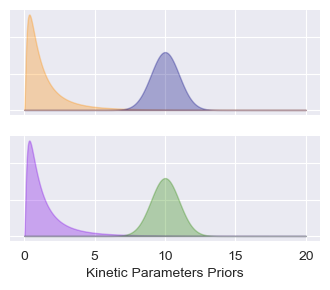

In [12]:
# plot the priors 



numpyro.set_host_device_count(4)
numpyro.set_platform("cpu")
numpyro.enable_validation()
jax.random.PRNGKey(42)
import numpyro.distributions as dist


Sanofi_color = ['#23004C', '#268500', '#7A00E6']
distribution_ = {"k1_f": dist.LogNormal(0, 1), 
                 "E1_f": dist.Normal(10, 1), 
                 "k2_f": dist.LogNormal(0, 1), 
                 "E2_f": dist.Normal(10, 1)
                 }


x = np.linspace(0, 20, 1000)
k1_f_dist = jnp.exp(dist.LogNormal(0, 1).log_prob(x))
k2_f_dist = jnp.exp(dist.LogNormal(0, 1).log_prob(x))
E1_f_dist = jnp.exp(dist.Normal(10, 1).log_prob(x))
E2_f_dist = jnp.exp(dist.Normal(10, 1).log_prob(x))


fig, axs = plt.subplots(2, 1, figsize=(4, 3))


axs[0].fill_between(x, 0, k1_f_dist, color='darkorange', alpha=0.3)
axs[0].fill_between(x, 0, E1_f_dist, color='navy', alpha=0.3)
axs[0].tick_params(axis='y', which='both', left=False, labelleft=False)
axs[0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
axs[0].tick_params(axis='y', which='both', left=False, labelleft=False)


axs[1].fill_between(x, 0, k1_f_dist, color=Sanofi_color[2], alpha=0.3)
axs[1].fill_between(x, 0, E1_f_dist, color=Sanofi_color[1], alpha=0.3)
axs[1].tick_params(axis='y', which='both', left=False, labelleft=False)
axs[1].set_xlabel('Kinetic Parameters Priors')
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)


In [13]:
def _new_priors3():
    k1_f = numpyro.sample("k1_f", dist.Normal(4.46, 0.02))
    E1_f = numpyro.sample("E1_f", dist.TruncatedNormal(11, 1, low=10, high=11.6)) 
    k2_f = numpyro.sample("k2_f", dist.Normal(6.01,  0.07))
    E2_f = numpyro.sample("E2_f", dist.TruncatedNormal(11, 1, low=10, high=11.6))
    return {"k1_f": k1_f,
            "E1_f": E1_f,
            "k2_f": k2_f,
            "E2_f": E2_f}

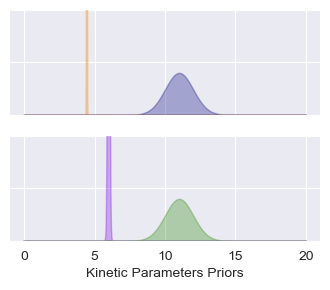

In [14]:
# plot the priors 



numpyro.set_host_device_count(4)
numpyro.set_platform("cpu")
numpyro.enable_validation()
jax.random.PRNGKey(42)
import numpyro.distributions as dist


Sanofi_color = ['#23004C', '#268500', '#7A00E6']
distribution_ = {"k1_f": dist.LogNormal(0, 1), 
                 "E1_f": dist.Normal(10, 1), 
                 "k2_f": dist.LogNormal(0, 1), 
                 "E2_f": dist.Normal(10, 1)
                 }


x = np.linspace(0, 20, 1000)
k1_f_dist = jnp.exp(dist.Normal(4.46, 0.02).log_prob(x))
k2_f_dist = jnp.exp(dist.Normal(6.01,  0.07).log_prob(x))
E1_f_dist = jnp.exp(dist.TruncatedNormal(11, 1).log_prob(x))
E2_f_dist = jnp.exp(dist.TruncatedNormal(11, 1).log_prob(x))


fig, axs = plt.subplots(2, 1, figsize=(4, 3))


axs[0].fill_between(x, 0, k1_f_dist, color='darkorange', alpha=0.3)
axs[0].fill_between(x, 0, E1_f_dist, color='navy', alpha=0.3)
axs[0].tick_params(axis='y', which='both', left=False, labelleft=False)
axs[0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
axs[0].tick_params(axis='y', which='both', left=False, labelleft=False)
axs[0].set_ylim(0, 1)  # Set y-axis limit to less than 1000


axs[1].fill_between(x, 0, k2_f_dist, color=Sanofi_color[2], alpha=0.3)
axs[1].fill_between(x, 0, E2_f_dist, color=Sanofi_color[1], alpha=0.3)
axs[1].tick_params(axis='y', which='both', left=False, labelleft=False)
axs[1].set_ylim(0, 1)
axs[1].set_xlabel('Kinetic Parameters Priors')
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)


In [9]:
# Preparing the experimental data and save them in a 1D array as y_exp_data 
import numpy as np 
SM_measured = []
P_measured = []
IMP_measured = []

for i in range(0, 5):
    SM_measured.append(df_raw.iloc[:, i * 4 + 1])
    P_measured.append(df_raw.iloc[:, i * 4 + 2])
    IMP_measured.append(df_raw.iloc[:, i * 4 + 3])


non_nan_values_SM  = np.concatenate(SM_measured)
non_nan_values_P   = np.concatenate(P_measured)
non_nan_values_IMP = np.concatenate(IMP_measured)


# # Calculate the measured_Y_without_Nan using non-NaN values arrays   
# ******NOTE ******this is where we apply weighting factor
# measured_Y_without_Nan =  non_nan_values_P +  non_nan_values_IMP
measured_Y_without_Nan = 0.9* non_nan_values_P + 0.1*non_nan_values_SM + 0.1*non_nan_values_IMP
nan_mask = jnp.isnan(measured_Y_without_Nan)
y_without_nan = measured_Y_without_Nan[~nan_mask]

# adding noise
noise_level = 0.0001
noise = np.random.normal(0, noise_level, y_without_nan.shape)
y_exp_data = y_without_nan + noise
X_dummy = X_measured
Y_dummy = y_exp_data

In [10]:
#out = reaction1.initilize_ODE_solver_for_numpyro_input(X_dummy, t, initial_species, [0.1,0,0,0.1,0.9])
reaction1_1.initilize_ODE_solver_for_numpyro_input(X_dummy, t, initial_species, [0.1,0,0,0.1,0.8])


5
['SM', 'reagent', 'base', 'IMP1', 'product']
The list of indices used to solve the ODE system is: {'SM': 0, 'reagent': 1, 'base': 2, 'IMP1': 3, 'product': 4}
Acq function weights: {'SM': 0.1, 'reagent': 0, 'base': 0, 'IMP1': 0.1, 'product': 0.8}


In [17]:
X_dummy2 = jnp.concatenate([X_dummy[12:24] ,X_dummy[48:60]])
Y_dummy2 = jnp.concatenate([Y_dummy[12:24] ,Y_dummy[48:60]])

In [13]:

BI_reaction1 = BayesianKineticAI()
BI_model = BI_reaction1.run_bayesian_inference(function = reaction1_1.simulate_symbolic_ode_for_numpyro,
    priors = _new_priors2, 
    X= X_dummy[12:24],
    Y= Y_dummy[12:24],
    num_samples=2000,
    num_warmup=1000)

sample: 100%|██████████| 3000/3000 [01:22<00:00, 36.28it/s, 7 steps of size 4.83e-01. acc. prob=0.90] 


In [11]:
input_new = jnp.concatenate([input_matrix.T, np.zeros((5, 1))], axis=1)

time = jnp.array([0.0, 15.0, 30.0, 45.0, 60.0, 90.0, 120.0, 180.0, 240.0, 360.0, 480.0, 540.0, 600.0, 780.0, 900.0, 960.0, 1207.0, 1374.0])


In [15]:
initial_species  = ['SM', 'reagent', 'base']
out_new = reaction1_1.initilize_ODE_solver_for_numpyro_input(input_new, time, initial_species, [0.1,0,0,0.1,0.9])

5
['SM', 'reagent', 'base', 'IMP1', 'product']
The list of indices used to solve the ODE system is: {'SM': 0, 'reagent': 1, 'base': 2, 'IMP1': 3, 'product': 4}
Acq function weights: {'SM': 0.1, 'reagent': 0, 'base': 0, 'IMP1': 0.1, 'product': 0.9}


In [20]:
y_predicted_all = BI_reaction1.bayesian_inference_predict(BI_model, 
                                        function = reaction1_1.simulate_symbolic_ode_for_numpyro_C_out,
                                        priors = _new_priors2, 
                                        X= input_new, 
                                        num_samples=2000,
                                        num_warmup=1000)

In [ ]:
y_predicted_all_test = y_predicted_all
%store y_predicted_all_test

In [22]:
%store -r y_predicted_all_test
y_predicted_all = y_predicted_all_test

In [ ]:
%store y_predicted_all


In [ ]:
%store -r y_predicted_all

In [12]:
C_out, names = reaction1_1.simulate_symbolic_ode_(input_new, ground_truth_params, time, initial_species=['SM', 'reagent', 'base'])

['SM', 'reagent', 'base', 'IMP1', 'product']


C:\Users\MalakM02\AppData\Local\Temp\ipykernel_9240\3950769410.py:53: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


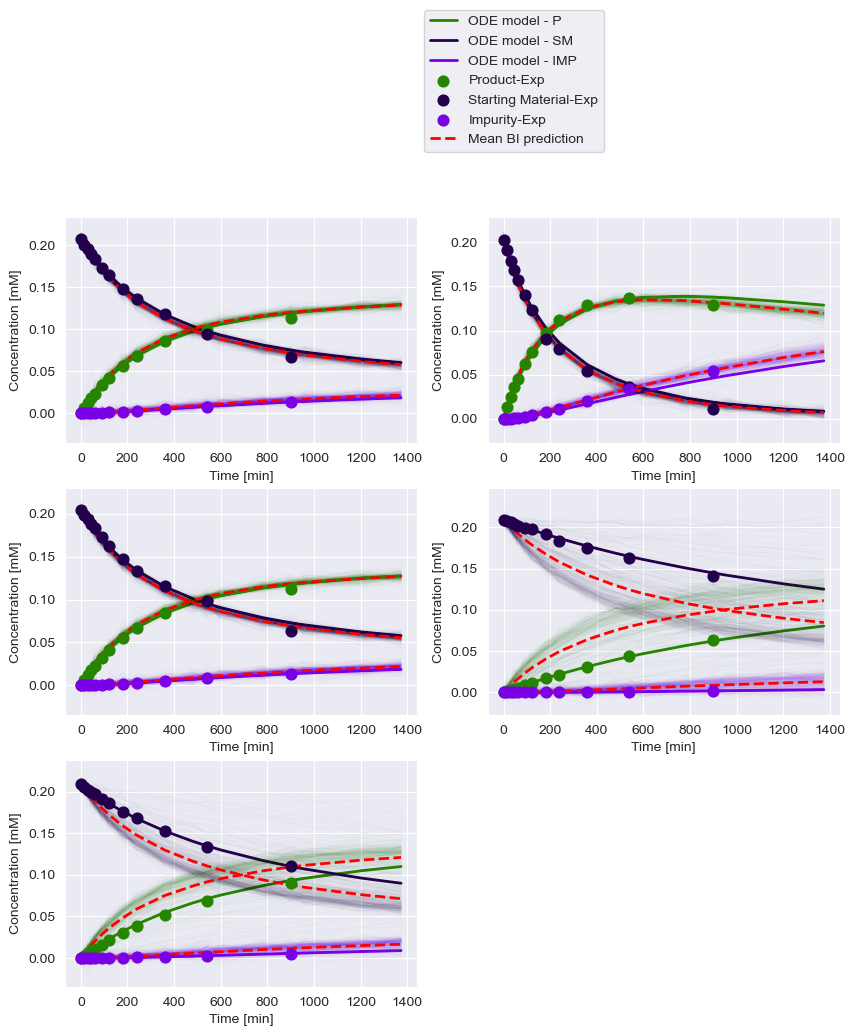

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

# subplot_index = 1
Sanofi_color = ['#23004C', '#268500', '#7A00E6']
# for i in range(0, 5):
#     plt.subplot(3, 2, subplot_index)
#     subplot_index += 1
#     for j in range(350):
#         plt.plot(time, y_predicted_all[j][:, i, -1], color=Sanofi_color[0], linewidth=1, alpha=0.01)
#         plt.plot(time, y_predicted_all[j][:, i, 0], color=Sanofi_color[1], linewidth=1, alpha=0.01)
#         plt.plot(time, y_predicted_all[j][:, i, -2], color=Sanofi_color[2], linewidth=1, alpha=0.01)
#     mean_predicted = np.mean([y_predicted_all[j][:, i] for j in range(2000)], axis=0)
#     plt.plot(time, mean_predicted[:, -1], color='red', linewidth=2, linestyle='--', label='Mean BI prediction')
#     plt.plot(time, mean_predicted[:, 0], color='red', linewidth=2, linestyle='--')
#     plt.plot(time, mean_predicted[:, -2], color='red', linewidth=2, linestyle='--')
#     plt.legend()

subplot_index_2 = 1
for i in range(0, 5):
    plt.subplot(3, 2, subplot_index_2)
    subplot_index_2 += 1
    plt.plot(time, C_out[:, i, -1], color=Sanofi_color[1], linewidth=2, label='ODE model - P')
    plt.plot(time, C_out[:, i, 0], color=Sanofi_color[0], linewidth=2, label='ODE model - SM')
    plt.plot(time, C_out[:, i, -2], color=Sanofi_color[2], linewidth=2, label='ODE model - IMP')
    plt.scatter(df_raw.iloc[:, i * 4], df_raw.iloc[:, i * 4 + 2], label='Product-Exp', s=60, color=Sanofi_color[1],  zorder=10)
    plt.scatter(df_raw.iloc[:, i * 4], df_raw.iloc[:, i * 4 + 1], label='Starting Material-Exp', s=60, color=Sanofi_color[0], zorder=10)
    plt.scatter(df_raw.iloc[:, i * 4], df_raw.iloc[:, i * 4 + 3], label='Impurity-Exp', s=60, color=Sanofi_color[2],  zorder=10)
    plt.xlabel('Time [min]')
    plt.ylabel('Concentration [mM]')

subplot_index = 1
Sanofi_color = ['#23004C', '#268500', '#7A00E6']
for i in range(0, 5):
    plt.subplot(3, 2, subplot_index)
    subplot_index += 1
    for j in range(300):
        plt.plot(time, y_predicted_all[j][:, i, 0], color=Sanofi_color[0], linewidth=1, alpha=0.01)
        plt.plot(time, y_predicted_all[j][:, i, -2], color=Sanofi_color[2], linewidth=1, alpha=0.01)
        plt.plot(time, y_predicted_all[j][:, i, -1], color=Sanofi_color[1], linewidth=1, alpha=0.01)
    # mean_predicted = np.mean([y_predicted_all[j][:, i] for j in range(10000)], axis=0)
    mean_predicted = np.mean([y_predicted_all[j][:, i] for j in range(len(y_predicted_all))], axis=0)


    plt.plot(time, mean_predicted[:, 0], color='red', linewidth=2, linestyle='--', label='Mean BI prediction')
    plt.plot(time, mean_predicted[:, -1], color='red', linewidth=2, linestyle='--')
    plt.plot(time, mean_predicted[:, -2], color='red', linewidth=2, linestyle='--')



    if i==4:
        plt.legend(loc='center left', bbox_to_anchor=(1,4))
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(10, 10))

subplot_index = 1
Sanofi_color = ['#23004C', '#268500', '#7A00E6']
# for i in range(0, 5):
#     plt.subplot(3, 2, subplot_index)
#     subplot_index += 1
#     for j in range(350):
#         plt.plot(t, y_predicted_all[j][:, i, 0], color=Sanofi_color[0], linewidth=1, alpha=0.01)
#         plt.plot(t, y_predicted_all[j][:, i, 1], color=Sanofi_color[1], linewidth=1, alpha=0.01)
#         plt.plot(t, y_predicted_all[j][:, i, 3], color=Sanofi_color[2], linewidth=1, alpha=0.01)
#     mean_predicted = np.mean([y_predicted_all[j][:, i] for j in range(2000)], axis=0)
#     plt.plot(t, mean_predicted[:, 0], color='red', linewidth=2, linestyle='--', label='Mean BI prediction')
#     plt.plot(t, mean_predicted[:, 1], color='red', linewidth=2, linestyle='--')
#     plt.plot(t, mean_predicted[:, 3], color='red', linewidth=2, linestyle='--')
#     # plt.legend()

subplot_index_2 = 1
for i in range(0, 5):
    plt.subplot(3, 2, subplot_index_2)
    subplot_index_2 += 1
    plt.plot(time, C_out[:, i, -1], color=Sanofi_color[2], linewidth=2, label='ODE model - P')
    plt.plot(time, C_out[:, i, 0], color=Sanofi_color[0], linewidth=2, label='ODE model - SM')  
    plt.plot(time, C_out[:, i, -2], color=Sanofi_color[1], linewidth=2, label='ODE model - IMP')
    # plt.scatter(df_raw.iloc[:, i * 4], df_raw.iloc[:, i * 4 + 2], label='Product-Exp', s=60, color=Sanofi_color[1],  zorder=10)
    # plt.scatter(df_raw.iloc[:, i * 4], df_raw.iloc[:, i * 4 + 1], label='Starting Material-Exp', s=60, color=Sanofi_color[0], zorder=10)
    # plt.scatter(df_raw.iloc[:, i * 4], df_raw.iloc[:, i * 4 + 3], label='Impurity-Exp', s=60, color=Sanofi_color[2],  zorder=10)
    plt.xlabel('Time [min]')
    plt.ylabel('Concentration [mM]')

subplot_index = 1
for i in range(0, 5):
    plt.subplot(3, 2, subplot_index)
    subplot_index += 1
    for j in range(300):
        plt.plot(time, y_predicted_all[j][:, i, 0], color=Sanofi_color[0], linewidth=1, alpha=0.01)
        plt.plot(time, y_predicted_all[j][:, i, -2], color=Sanofi_color[1], linewidth=1, alpha=0.01)
        plt.plot(time, y_predicted_all[j][:, i, -1], color=Sanofi_color[2], linewidth=1, alpha=0.01)
    mean_predicted = np.mean([y_predicted_all[j][:, i] for j in range(len(y_predicted_all))], axis=0)
    
    plt.plot(time, mean_predicted[:, 0], color='red', linewidth=2, linestyle='--', label='Mean BI prediction')
    plt.plot(time, mean_predicted[:, -1], color='red', linewidth=2, linestyle='--')
    plt.plot(time, mean_predicted[:, -2], color='red', linewidth=2, linestyle='--')


    
    if i==4:
        plt.legend(loc='center left', bbox_to_anchor=(1,4))
plt.tight_layout()
plt.show()


In [ ]:
# sample: 100%|██████████| 3000/3000 [00:13<00:00, 225.12it/s, 5 steps of size 4.86e-01. acc. prob=0.88] 

#                 mean       std    median      5.0%     95.0%     n_eff     r_hat
#       E1_f      9.97      0.98      9.97      8.38     11.55   1813.24      1.00
#       E2_f     10.00      0.95     10.00      8.56     11.62   1978.75      1.00
#       k1_f      4.40      0.04      4.41      4.34      4.46    723.92      1.00
#       k2_f      5.99      0.09      5.99      5.85      6.14    627.98      1.00
#      sigma      0.00      0.00      0.00      0.00      0.00    667.37      1.00

numpyro.set_host_device_count(4)
numpyro.set_platform("cpu")
numpyro.enable_validation()
jax.random.PRNGKey(42)
mu = 0
sigma = 1


# Generate samples from the LogNormal distribution
distribution_ = dist.Normal(4.40, 0.04)
distribution_ = dist.Normal(5.99,  0.09)

# distribution_ = dist.TruncatedNormal(11, 1, low=10, high=11.6)
# # distribution_  = dist.LogNormal(2.3, 0.1).expand_by([1]).to_event(1).mask(False)
num_samples = 500
# Sample from the distribution
samples =  distribution_.sample(jax.random.PRNGKey(123), (num_samples,))


fig = plt.figure(figsize=(10, 6))
sns.histplot(samples)
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [24]:
def _new_priors3():
    k1_f = numpyro.sample("k1_f", dist.Normal(4.40, 0.04))
    E1_f = numpyro.sample("E1_f", dist.Normal(10, 1)) 
    k2_f = numpyro.sample("k2_f", dist.Normal(5.99,  0.09))
    E2_f = numpyro.sample("E2_f", dist.Normal(10, 1))
    return {"k1_f": k1_f,
            "E1_f": E1_f,
            "k2_f": k2_f,
            "E2_f": E2_f}

In [13]:
def _new_priors3():
    k1_f = numpyro.sample("k1_f", dist.Normal(4.46, 0.02))
    E1_f = numpyro.sample("E1_f", dist.TruncatedNormal(11, 1, low=10, high=11.6)) 
    k2_f = numpyro.sample("k2_f", dist.Normal(6.01,  0.07))
    E2_f = numpyro.sample("E2_f", dist.TruncatedNormal(11, 1, low=10, high=11.6))
    return {"k1_f": k1_f,
            "E1_f": E1_f,
            "k2_f": k2_f,
            "E2_f": E2_f}

In [14]:
initial_species  = ['SM', 'reagent', 'base']
out_new = reaction1_1.initilize_ODE_solver_for_numpyro_input(X_dummy, time, initial_species, [0.1,0,0,0.1,0.9])

5
['SM', 'reagent', 'base', 'IMP1', 'product']
The list of indices used to solve the ODE system is: {'SM': 0, 'reagent': 1, 'base': 2, 'IMP1': 3, 'product': 4}
Acq function weights: {'SM': 0.1, 'reagent': 0, 'base': 0, 'IMP1': 0.1, 'product': 0.9}


In [15]:
BI_reaction1_new = BayesianKineticAI()
BI_model = BI_reaction1_new.run_bayesian_inference(function = reaction1_1.simulate_symbolic_ode_for_numpyro,
    priors = _new_priors3, 
    X= X_dummy[12:24],
    Y= Y_dummy[12:24],
    num_samples=2000,
    num_warmup=1000)

sample: 100%|██████████| 3000/3000 [00:38<00:00, 77.12it/s, 7 steps of size 6.10e-01. acc. prob=0.88]  


In [16]:
# run plots again 

y_predicted_all2 = BI_reaction1_new.bayesian_inference_predict(BI_model,
                                        function = reaction1_1.simulate_symbolic_ode_for_numpyro_C_out,
                                        priors = _new_priors3, 
                                        X= input_new, 
                                        num_samples=2000,
                                        num_warmup=1000)


In [ ]:
y_predicted_all_test2 = y_predicted_all2
%store y_predicted_all_test2

In [ ]:
%store y_predicted_all2

In [ ]:
%store -r y_predicted_all2

In [ ]:
%store -r y_predicted_all_test2
y_predicted_all2 = y_predicted_all_test2

In [ ]:
print(np.max(y_predicted_all2))
np.min(y_predicted_all2)

C:\Users\MalakM02\AppData\Local\Temp\ipykernel_50952\3013272395.py:52: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


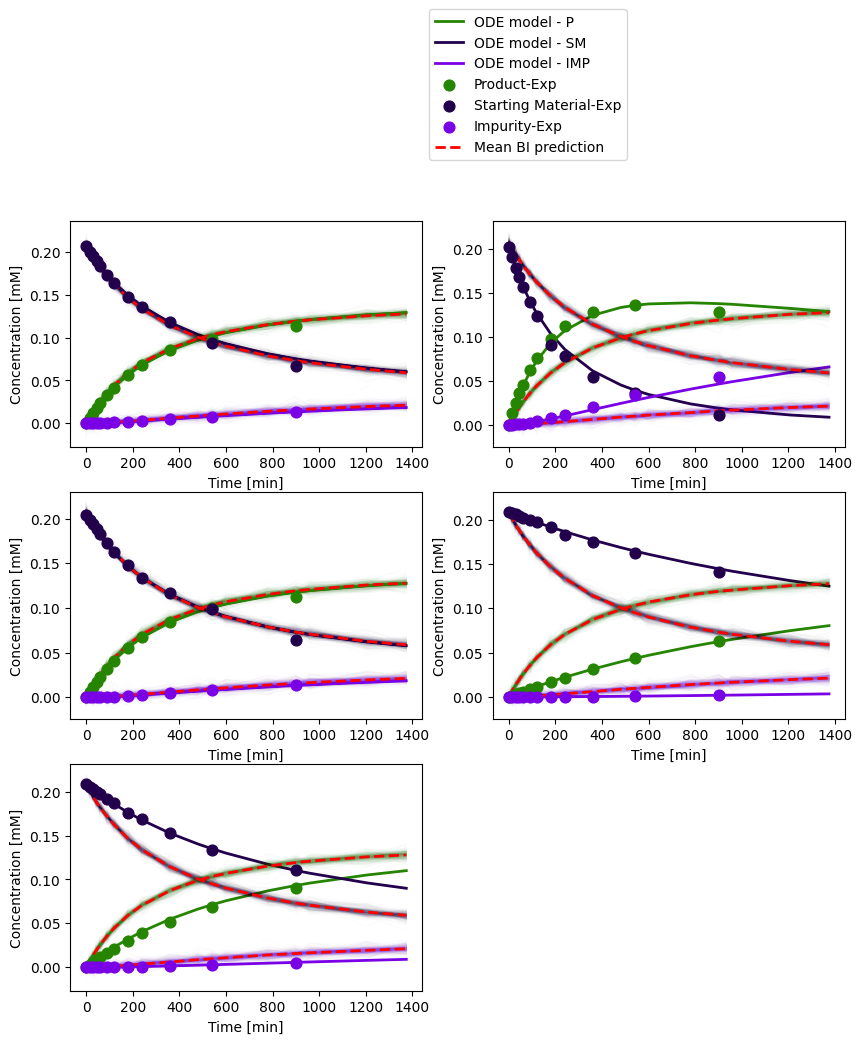

In [17]:
plt.figure(figsize=(10, 10))
subplot_index = 1
Sanofi_color = ['#23004C', '#268500', '#7A00E6']
# for i in range(0, 5):
#     plt.subplot(3, 2, subplot_index)
#     subplot_index += 1
#     for j in range(350):
#         plt.plot(t, y_predicted_all[j][:, i, 0], color=Sanofi_color[0], linewidth=1, alpha=0.01)
#         plt.plot(t, y_predicted_all[j][:, i, 1], color=Sanofi_color[1], linewidth=1, alpha=0.01)
#         plt.plot(t, y_predicted_all[j][:, i, 3], color=Sanofi_color[2], linewidth=1, alpha=0.01)
#     mean_predicted = np.mean([y_predicted_all[j][:, i] for j in range(2000)], axis=0)
#     plt.plot(t, mean_predicted[:, 0], color='red', linewidth=2, linestyle='--', label='Mean BI prediction')
#     plt.plot(t, mean_predicted[:, 1], color='red', linewidth=2, linestyle='--')
#     plt.plot(t, mean_predicted[:, 3], color='red', linewidth=2, linestyle='--')
#     # plt.legend()

subplot_index_2 = 1
for i in range(0, 5):
    ax = plt.subplot(3, 2, subplot_index_2)
    subplot_index_2 += 1
    plt.plot(time, C_out[:, i, -1], color=Sanofi_color[1], linewidth=2, label='ODE model - P')
    plt.plot(time, C_out[:, i, 0], color=Sanofi_color[0], linewidth=2, label='ODE model - SM')
    plt.plot(time, C_out[:, i, -2], color=Sanofi_color[2], linewidth=2, label='ODE model - IMP')
    plt.scatter(df_raw.iloc[:, i * 4], df_raw.iloc[:, i * 4 + 2], label='Product-Exp', s=60, color=Sanofi_color[1],  zorder=10)
    plt.scatter(df_raw.iloc[:, i * 4], df_raw.iloc[:, i * 4 + 1], label='Starting Material-Exp', s=60, color=Sanofi_color[0], zorder=10)    
    plt.scatter(df_raw.iloc[:, i * 4], df_raw.iloc[:, i * 4 + 3], label='Impurity-Exp', s=60, color=Sanofi_color[2],  zorder=10)
    plt.xlabel('Time [min]')
    plt.ylabel('Concentration [mM]')
    #ax.set_ylim(0,0.2)

subplot_index = 1
Sanofi_color = ['#23004C', '#268500', '#7A00E6']
for i in range(0, 5):
    ax = plt.subplot(3, 2, subplot_index)
    subplot_index += 1
    for j in range(300):
        plt.plot(time, y_predicted_all2[j][:, i, 0], color=Sanofi_color[0], linewidth=1, alpha=0.01)
        plt.plot(time, y_predicted_all2[j][:, i, -2], color=Sanofi_color[2], linewidth=1, alpha=0.01)
        plt.plot(time, y_predicted_all2[j][:, i, -1], color=Sanofi_color[1], linewidth=1, alpha=0.01)
    # mean_predicted = np.mean([y_predicted_all2[j][:, i] for j in range(10000)], axis=0)
    mean_predicted = np.mean([y_predicted_all2[j][:, i] for j in range(len(y_predicted_all2))], axis=0)

    plt.plot(time, mean_predicted[:, 0], color='red', linewidth=2, linestyle='--', label='Mean BI prediction')
    plt.plot(time, mean_predicted[:, -1], color='red', linewidth=2, linestyle='--')
    plt.plot(time, mean_predicted[:, -2], color='red', linewidth=2, linestyle='--')
    #ax.set_ylim(0,0.2)


    
    if i==4:
        plt.legend(loc='center left', bbox_to_anchor=(1,4))
plt.tight_layout()
plt.show()


In [ ]:
#plot ODE solver
 
# define the initial conditions

                 # T  SM_0   R_0   B_0 
X1 = jnp.array([81.9, 0.208, 0.2, 0.405])
X2 = jnp.array([81.9, 0.203, 0.4, 0.405])
X3 = jnp.array([81.9, 0.204, 0.2, 0.811])
X4 = jnp.array([61.1, 0.209, 0.2, 0.406])
X5 = jnp.array([71.0, 0.209, 0.2, 0.407])

X1 = jnp.reshape(X1, (4, 1))
X2 = jnp.reshape(X2, (4, 1))
X3 = jnp.reshape(X3, (4, 1))
X4 = jnp.reshape(X4, (4, 1))
X5 = jnp.reshape(X5, (4, 1))

input_matrix = jnp.concatenate([X1, X2, X3, X4, X5], axis=1)

# time = jnp.array([0.0, 30.0, 60.0, 90.0, 120.0, 180.0, 240.0, 360.0, 480.0, 600.0, 780.0, 960.0, 1207.0, 1374.0])
time = jnp.array([0.0, 15.0, 30.0, 45.0, 60.0, 90.0, 120.0, 180.0, 240.0, 360.0, 480.0, 540.0, 600.0, 780.0, 900.0, 960.0, 1207.0, 1374.0])

# time = jnp.array([0.0, 15.0, 30.0, 45.0, 60.0, 90.0, 120.0, 180.0, 240.0, 360.0,  540.0,  900.0])



ground_truth_params = {
"k1_f": 0.011,
"E1_f": 70.2E3,
"k2_f": 0.002,
"E2_f": 78.92E3,
}

mean_params = {
"k1_f": jnp.exp(-4.50),
"E1_f": jnp.exp(11.15),
"k2_f": jnp.exp(-6.20),
"E2_f": jnp.exp(11.27),
}


df_raw = pd.read_csv("example_2_experimental_data2.csv", engine='python')
C_out, names = reaction1.simulate_symbolic_ode_(input_matrix.T, ground_truth_params, time, initial_species=['SM','reagent','base'])


In [ ]:
# get samples and plot the Posterior Distributions

import corner
import arviz as az
from pyro.infer import MCMC, NUTS
hmc_samples = BI_model.get_samples().items()

In [ ]:
def summary(samples):
    site_stats = {}
    for site_name, values in samples:
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

In [ ]:
import numpy as np
import corner

hmc_samples_array = np.array([hmc_samples_dict[var_name] for var_name in ["E1_f", "E2_f", "k1_f", "k2_f"]]).T

ground_truth_array = np.array([ground_truth_params_log[var_name] for var_name in ["E1_f", "E2_f", "k1_f", "k2_f"]])

figure = corner.corner(
    hmc_samples_array,
    labels=["E1_f", "E2_f", "k1_f", "k2_f"],
    range=[(9,12), (9, 12), (4.2, 4.7), (5, 7)], 
    color='purple',
    truths=ground_truth_array,
    truth_color="Green"
)
# figure = corner.corner(
#     hmc_samples_array,
#     labels=["E1_f", "E2_f", "k1_f", "k2_f"],
#     color='purple',
#     truths=ground_truth_array,
#     truth_color="Green"
# )
# figure.show()
